# Debiasing Facial Detection System
This lab is about removing the biase from the facial detection system. Lets get started.

# 1 Imports

In [17]:
#1 Imports

import os
import random
import IPython
import functools
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.backends import cudnn


#import mit
import mitdeeplearning as mdl
import comet_ml
import tqdm as tqdm

# 2 Datasets
- 3 different datasets are used.
- - Positive: CelebA Dataset: Celebrity Faces
- - Negative: ImageNet : Not faces
- - Fitzpatrick Scale : Skin Type Classification 


In [4]:
# Downloading the dataset
CACHE_DIR = Path.cwd() /".cache" / "mitdeeplearning"
CACHE_DIR.mkdir(parents = True, exist_ok = True)
print (f"Path : {CACHE_DIR}")

#Get the training data from both  datasets
path_to_training_data = CACHE_DIR.joinpath("train_face.h5")
print (f"Path to training data: {path_to_training_data}")


#Create a simple check to avoid re-downloading the dataset
if path_to_training_data.is_file():
    print(f"Using Cache Data : {path_to_training_data}")
else:
    print(f"Downloading dataset to {path_to_training_data} ")
    url = "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
    torch.hub.download_url_to_file(url, path_to_training_data)



Path : d:\DL_Repos\introtodeeplearning\HayatLabs\.cache\mitdeeplearning
Path to training data: d:\DL_Repos\introtodeeplearning\HayatLabs\.cache\mitdeeplearning\train_face.h5
Using Cache Data : d:\DL_Repos\introtodeeplearning\HayatLabs\.cache\mitdeeplearning\train_face.h5


In [5]:
# Institate a Training DataSetLoader using the downloaded dataset
channels_last = False
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data,channels_last=channels_last)

number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100) # it give us numpay array of images and labels

Opening d:\DL_Repos\introtodeeplearning\HayatLabs\.cache\mitdeeplearning\train_face.h5
Loading data into memory...


In [6]:
B, C, H, W = images.shape
print(f"Batch Size: {B}, Channels: {C}, Height: {H}, Width: {W}")

Batch Size: 100, Channels: 3, Height: 64, Width: 64


In [7]:
import ipywidgets as widgets
from IPython.display import display

# Examining the dataset
def show_images(idx_face=0, idx_not_face=0):
    face_images = images[np.where(labels==1)[0]].transpose(0,2,3,1)
    not_faces_images = images[np.where(labels==0)[0]].transpose(0,2,3,1)

    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(face_images[idx_face])
    plt.title("Face")
    plt.grid(False)

    plt.subplot(1,2,2)
    plt.imshow(not_faces_images[idx_not_face])
    plt.title("Not Face")
    plt.grid(False)
    
    plt.show()

widgets.interact(show_images, idx_face=(0, 49), idx_not_face=(0, 49))

interactive(children=(IntSlider(value=0, description='idx_face', max=49), IntSlider(value=0, description='idx_…

<function __main__.show_images(idx_face=0, idx_not_face=0)>

In [8]:
# To confirm that loader give us numpy array
#(images, labels) = loader.get_batch(100)
print(type(images))
print(type(labels))
print(f"Images shape: {images.shape}" )            

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Images shape: (100, 3, 64, 64)


In [9]:
# Import h5py library to explore HDF5 file metadata
import h5py
with h5py.File (path_to_training_data, 'r') as f:
    print(f"Exploring h5 dataset")
    print(f"Number of Folders in h5: {len(f.keys())}")
    print(f"Names of folders : {list(f.keys())}")
    for k in f.keys():
        dataset = f[k]
        print(f"Dataset Name: {k}")
        print(f"Shape: {dataset.shape} ")
        print(f"Data Type: {dataset.dtype}")    

Exploring h5 dataset
Number of Folders in h5: 2
Names of folders : ['images', 'labels']
Dataset Name: images
Shape: (109914, 64, 64, 3) 
Data Type: uint8
Dataset Name: labels
Shape: (109914, 1) 
Data Type: uint8


Folder in h5 File: ['images', 'labels']
Image 0: Shape (64, 64, 3), Label: [0] (Not Face)


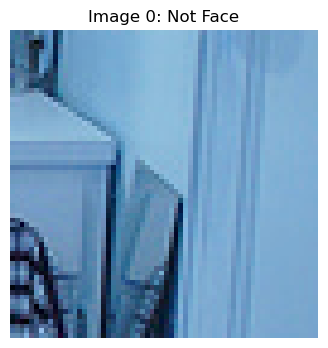

Image 50: Shape (64, 64, 3), Label: [0] (Not Face)


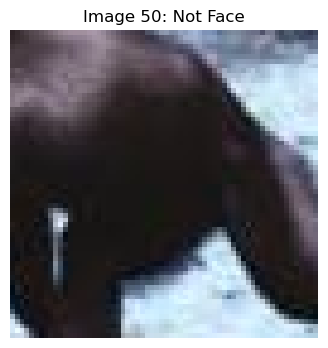

Image 100: Shape (64, 64, 3), Label: [0] (Not Face)


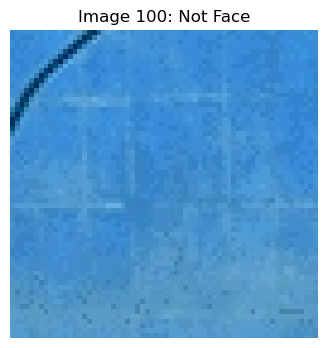

Image 200: Shape (64, 64, 3), Label: [0] (Not Face)


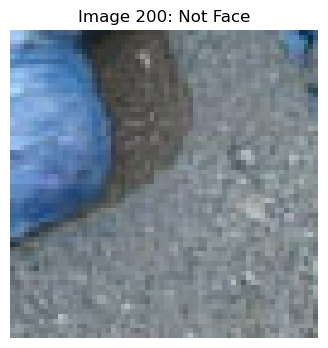

In [10]:
# 3 Display the First Image 
with h5py.File (path_to_training_data,'r') as f:
    print(f"Folder in h5 File: {list(f.keys())}")
    if 'images' in f.keys():
        # Try different indices and check corresponding labels
        for idx in [0, 50, 100, 200]:
            image = f['images'][idx]
            label = f['labels'][idx]
            print(f"Image {idx}: Shape {image.shape}, Label: {label} ({'Face' if label==1 else 'Not Face'})")
            
            # Convert image format for display (CHW to HWC)
            if len(image.shape) == 3 and image.shape[0] == 3:
                display_image = image.transpose(1, 2, 0)  # CHW to HWC
            else:
                display_image = image
            
            # Normalize pixel values to [0,1] range if needed
            if display_image.max() > 1:
                display_image = display_image / 255.0
                
            plt.figure(figsize=(4,4))
            plt.imshow(display_image)
            plt.title(f"Image {idx}: {'Face' if label==1 else 'Not Face'}")
            plt.axis('off')
            plt.show()
            
            # Stop after finding a face
            if label == 1:
                break


# CNN for FAcial Detection

In [20]:
# Define the cnn model
n_filters = 12
in_channel = images.shape[1]

def make_standard_classifier(n_outputs):
    class ConvBlock(nn.Module):
        def __init__(self,in_channels,out_channels,kernel_size, stride,padding=0):
            super(). __init__()
            self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding)
            self.relu = nn.ReLU(inplace = True)
            self.bn = nn.BatchNorm2d(out_channels)

        def forward (self,x):
            x = self.conv(x)
            x = self.relu(x)
            x = self.bn(x)
            return x
    model = nn.Sequential(
        ConvBlock(in_channel,n_filters,kernel_size=5,stride=2,padding=2),
        ConvBlock(n_filters,2*n_filters,kernel_size=5,stride=2,padding=2),
        ConvBlock(2*n_filters,4*n_filters,kernel_size=3,stride=2,padding=1),
        ConvBlock(4*n_filters,6*n_filters, kernel_size=3,stride=2,padding=1),
        nn.Flatten(),
        nn.Linear(H //16 * W //16 * 6*n_filters,512), #(H*W*n_filter) divide the H and W by (2 ^ number convolution layers )
        nn.ReLU(inplace=True),
        nn.Linear(512,n_outputs),
        )
    return model.to('cuda')

#call the function to instantiate a classifier model
standard_classifier = make_standard_classifier(n_outputs=1)
print(standard_classifier)


Sequential(
  (0): ConvBlock(
    (conv): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): ConvBlock(
    (conv): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ConvBlock(
    (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): ConvBlock(
    (conv): Conv2d(48, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1152, out_features=512, bias=True)
  (6

In [21]:
# Lets Train the Standard CNN

api_key = "Xg2mJUP2iMIjlVOUSERvKB3IN"
proj = "HLab_4"
def create_experiment(project_name,params):
    experiment  = comet_ml.Experiment (api_key=api_key, project_name= proj)  

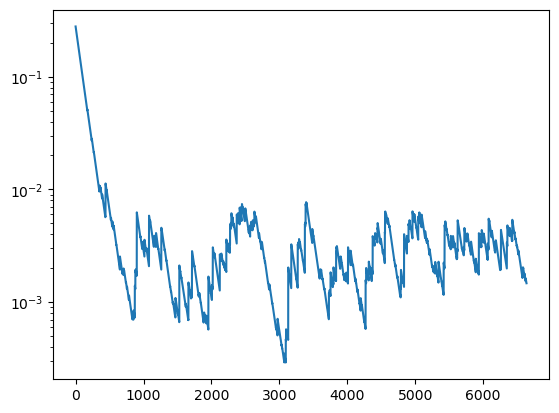

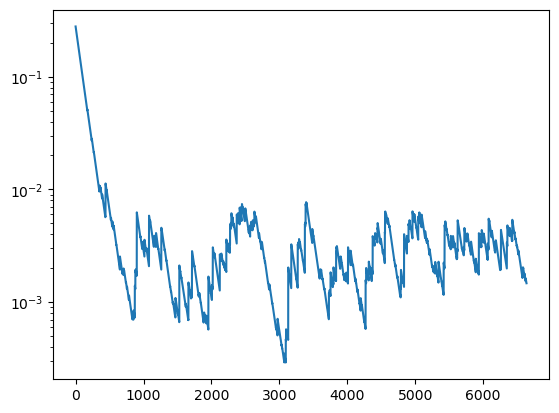

In [27]:
# Train the Standard CNN

loss_fn = torch.nn.BCEWithLogitsLoss()

# Training Parameters

params = dict( 
    batch_size = 32,
    num_epochs=2, # Keep small for faster run
    learning_rate = 5e-4,
    )

#experiment = create_experiment ("Hlab_4_experiment", params)
optimizer = optim.Adam (standard_classifier.parameters(), lr = params['learning_rate'])

loss_history = mdl.util.LossHistory(smoothing_factor=0.99)
plotter = mdl.util.PeriodicPlotter ( sec= 2, scale = 'semilogy')

if hasattr(tqdm, '._instances'):
    tqdm._instances.clear()

standard_classifier.train()

def standard_train_step(x,y):
    x = torch.from_numpy(x).float().to('cuda')
    y = torch.from_numpy(y).float().to('cuda')

    #clear the gradient
    optimizer.zero_grad()

    #feed the images
    logits = standard_classifier(x)

    #computer the loss
    loss = loss_fn(logits,y)

    #backpropagation
    loss.backward()
    optimizer.step()

    return loss

# The Training Loop

step = 0
for epoch in range(params['num_epochs']):
    for idx in (range(loader.get_train_size() // params['batch_size'])):
        #grab a batch of training data and propogate through the network
        x,y = loader.get_batch(params['batch_size'])
        loss = standard_train_step(x,y)
        loss_value = loss.detach().cpu().numpy()

        #Record the loss and plot
        loss_history.append(loss_value)
        plotter.plot(loss_history.get())

       # experiment.log_metric("loss", loss_value, step=step)
        #step += 1

#experiment.end()


